# building train and test datasets:

In [1]:
# building train and test datasets:
import pandas as pd
import numpy as np

from sklearn.metrics import fbeta_score

pd.options.display.max_colwidth=100
pd.options.display.max_columns=300

employees = pd.read_csv("../data/employees.csv")
history = pd.read_csv("../data/history.csv")
submission = pd.read_csv("../data/submission.csv")

history.loc[:,'Date'] = list(pd.to_datetime(history['Date']))

def get_month(text):
    if type(text) == str:
        numbers = text.split("/")
        return int(numbers[0])

def get_year(text):
    if type(text) == str:
        numbers = text.split("/")
        return int(numbers[-1])

df = history.merge(employees)

# for data labeling
def label_df(data, n_month=3):
    labels = []
    for emp in data.EmployeeID.unique():
        curr_emp = list(data[data.EmployeeID == emp]['DismissalDate'])
        len_emp = len(curr_emp)
        if pd.isnull(curr_emp[0]):
            labels += [0 for _ in range(len_emp)]
        else:
            labels += [0 for _ in range(len_emp - 3)] + [1,1,1]
    return labels

lbls = label_df(df)
df['target'] = lbls
df = df[df.target!=6]

In [2]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

columns_to_drop = ['Date','HiringDate', 'DismissalDate']

cat_columns = ['DevCenterID', 'SBUID', 'PositionID', 'PositionLevel', 
               'IsTrainee', 'LanguageLevelID', 'CustomerID', 'ProjectID', 
               'IsInternalProject', 'OnSite', 'CompetenceGroupID', 'FunctionalOfficeID',
               'PaymentTypeId']

X = df.drop(columns_to_drop, axis = 1)

from category_encoders.basen import BaseNEncoder
encoder = BaseNEncoder(cols = cat_columns, base = 3)

X = encoder.fit_transform(X)
X = X.reset_index()

tmp = X.EmployeeID
target = X.target
X.drop(['EmployeeID', 'target'], axis = 1, inplace = True)

cols = X.columns
X = pd.DataFrame(scaler.fit_transform(X), columns = cols)
X['target'] = target
X['EmployeeID'] = tmp

In [3]:
testing_empls = list(set(X.EmployeeID)-set(submission.EmployeeID))[15:30]

val_set = X[X.EmployeeID.isin(set(testing_empls))]
val_set = val_set.groupby('EmployeeID').tail(6)
train_set = X.drop(val_set.index)

test_set = X[X.EmployeeID.isin(set(submission.EmployeeID))]
test_set = test_set.groupby('EmployeeID').tail(3)
train_set = train_set.drop(test_set.index)

train_set.drop('index', axis = 1, inplace = True)
test_set.drop('index', axis = 1, inplace = True)
val_set.drop('index', axis = 1, inplace = True)

In [4]:
### test dataset:
import tensorflow as tf

cols = list(test_set.columns)
cols.pop(-1)
cols.pop(-1)

X_test = [person[1][cols].values for person in test_set.groupby('EmployeeID')]

/Users/trokhymovych/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/trokhymovych/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/trokhymovych/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/trokhymovych/.local/lib/python3.7/site-packages/tensorflow/pyth

In [5]:
### test dataset:
import tensorflow as tf

cols = list(test_set.columns)
cols.pop(-1)
cols.pop(-1)


X_val = [person[1][cols].values for person in val_set.groupby('EmployeeID')]
y_val = [person[1]['target'].values for person in val_set.groupby('EmployeeID')]

In [6]:
### train dataset:
import tensorflow as tf
from tqdm import tqdm

cols = list(train_set.columns)
cols.pop(-1)

data = [person[1][cols].values for person in train_set.groupby('EmployeeID')]

# getting subsequences:
def get_subsequence(sequence):
    if sequence.shape[0]<6:
        return []
#     if (sequence.shape[0]>=2) and (sequence.shape[0]<6):
#         return [sequence]
    else:
        tmp_data = []
        for i in range(0, sequence.shape[0]-5):
            tmp_data.append(sequence[i:i+6])
        return tmp_data

sub_data = []
for x in tqdm(data):
    sub_data = sub_data + get_subsequence(x)

# x_train = [x[:-1,:-1].flatten() for x in sub_data]

# # y_train = tf.keras.utils.to_categorical([x[-1, -1] for x in data])   # Expects class labels from 0 to n (-> subtract 1).
# y_train = [x[-1, -1] for x in sub_data]
# print(len(x_train))
# print(len(y_train))

100%|██████████| 5373/5373 [00:00<00:00, 8040.57it/s] 


In [7]:
train_X = []
train_y = []
for el in sub_data:
    train_X += [i[:-1] for i in el]
    train_y += [i[-1] for i in el]
    
print(len(train_X))
print(len(train_y))

292674
292674


In [8]:
test_X = []
for el in X_test:
    test_X += [i for i in el]
len(test_X)

12468

In [9]:
val_X = []
for el in X_val:
    val_X += [i for i in el]
val_y = []
for el in y_val:
    val_y += [i for i in el]
val_X[0].shape

(66,)

In [10]:
# from sklearn.model_selection import train_test_split
# X, X_val, y, y_val = train_test_split(train_X, train_y, test_size=0.05, random_state=42)

# Training the model:

In [46]:
import pandas as pd
import tensorflow as tf
import keras
from tensorflow.keras import regularizers

from keras import backend as K
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

# def recall_m(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     recall = true_positives / (possible_positives)
#     return recall

# def precision_m(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives)
#     return precision

# def f1_m(y_true, y_pred):
#     precision = precision_m(y_true, y_pred)
#     recall = recall_m(y_true, y_pred)
#     return (1+1.7**2)*((precision*recall)/(1.7**2*precision+recall))


# model = tf.keras.models.Sequential()
# model.add(tf.keras.layers.Dense(1000, activation='relu', input_dim=90, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),))
# model.add(tf.keras.layers.Dense(500, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),))
# model.add(tf.keras.layers.Dense(1))
# optimizer = tf.keras.optimizers.Adam(lr=0.001)

# model.compile(loss='mse', optimizer=optimizer, metrics=['mse'])
# # fit the keras model on the dataset
# model.fit(np.array(train_X), train_y, epochs=40, validation_split=0.2, batch_size=512)


batch_size = 256
original_dim = 66
intermediate_dim = 100
latent_dim = 1
epsilon_std = 0.1
epochs = 50


x = Input(shape = (original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(latent_dim,),
                              mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_sigma) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)


# end-to-end autoencoder
vae = Model(x, x_decoded_mean)

# encoder, from inputs to latent space
encoder = Model(x, z_mean)

# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

def vae_loss(x, x_decoded_mean):
    xent_loss = binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return xent_loss + kl_loss

vae.compile(optimizer='adam', loss=vae_loss)

vae.fit(np.array(train_X), np.array(train_y),
        validation_split=0.05,
        shuffle=True,
        epochs=20,
        batch_size=batch_size,
        verbose = 1)



Train on 278040 samples, validate on 14634 samples
Epoch 1/20
278040/278040 [==============================] - 2s - loss: 0.1468 - val_loss: 0.0915
Epoch 2/20
278040/278040 [==============================] - 2s - loss: 0.0940 - val_loss: 0.0889
Epoch 3/20
278040/278040 [==============================] - 2s - loss: 0.0918 - val_loss: 0.0950
Epoch 4/20
278040/278040 [==============================] - 2s - loss: 0.0894 - val_loss: 0.0898
Epoch 5/20
278040/278040 [==============================] - 2s - loss: 0.0880 - val_loss: 0.0951
Epoch 6/20
278040/278040 [==============================] - 2s - loss: 0.0856 - val_loss: 0.0991
Epoch 7/20
278040/278040 [==============================] - 2s - loss: 0.0853 - val_loss: 0.1047
Epoch 8/20
278040/278040 [==============================] - 2s - loss: 0.0832 - val_loss: 0.1053
Epoch 9/20
278040/278040 [==============================] - 2s - loss: 0.0824 - val_loss: 0.1049
Epoch 10/20
278040/278040 [==============================] - 2s - loss: 0.08

In [54]:
pred = encoder.predict(np.array(val_X))
val_y = np.array(val_y)

pred_new = []
val_new = []
for i in range(0, len(val_X) -2,3):
    pred_new.append(pred[i:i+3].mean(axis = 0))
    val_new.append(val_y[i:i+3].mean(axis = 0))
pred_new = np.array(pred_new)

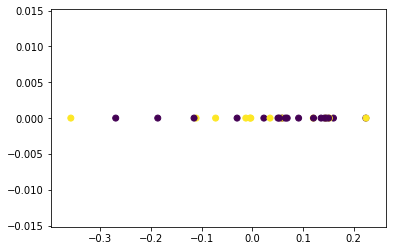

In [55]:
import matplotlib.pyplot as plt
plt.scatter(pred_new[:,0], y = np.zeros(len(pred_new)), c = val_new)
# plt.legend()

In [63]:
(pred_new.flatten()<0.05).astype(int)

array([0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 1])

In [80]:
pred = encoder.predict(np.array(test_X))
pred_new = []
val_new = []

for i in range(0, len(test_X) -2,3):
    pred_new.append(pred[i:i+3].min(axis = 0))
#     val_new.append(val_y[i:i+3].mean(axis = 0))
pred_new = np.array(pred_new)

In [81]:
pred_new = (pred_new.flatten()<0.).astype(int)

In [82]:
sum(pred_new)

1718

In [361]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)


###### Testing prediction logic
preds = model.predict(np.array(test_X)).flatten()

In [385]:
pp = []
for i in range(0,len(preds)-4,5):
    tmp = preds[i:i+5]
    if len(np.where(tmp>100)[0])>0 or (tmp[1:] == np.sort(tmp[1:])).all():
        pp.append(1)
    else:
        pp.append(0)
    

In [386]:
sum(pp)

1902

In [83]:
from datetime import datetime

# X_test = np.array(X_test)
# preds = model.predict(X_test)
epms = list(test_set.groupby('EmployeeID').count().index)

result = pd.DataFrame({'EmployeeID':epms, 'target':pred_new})

result.to_csv('Mykola_super_ugadaika_3.csv', index = False)

In [73]:
sum(pred_new)

2356

In [85]:
X = np.array(train_X)
y = np.array(train_y)

In [87]:
X.shape

(292674, 66)

In [ ]:
# !pip install imblearn
from sklearn.model_selection import KFold
# from sklearn.ensemble import RandomForestClassifier
# from imblearn.ensemble import RUSBoostClassifier
# from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.svm import SVC
import random

RANDOM_SEED = 42

def set_seed(random_state=RANDOM_SEED):
    random.seed(random_state)
    np.random.seed(random_state)

# def model_fit(X_train, y_train):
#     clf2 = RUSBoostClassifier(n_estimators=200)
#     clf2 = clf2.fit(X_train, y_train)
#     return clf2

# def model_predict(X, models):
#     preds = models.predict(X)
#     return preds

def model_fit(X_train, y_train):
    clf2 = SVC(class_weight = 'balanced')
    clf2 = clf2.fit(X_train, y_train)
    return clf2

def model_predict(X, models):
    preds = models.predict(X)
    return preds

# def model_fit(X_train, y_train):
#     model = tf.keras.models.Sequential()
#     model.add(tf.keras.layers.Dense(2000, activation='relu', input_dim=455,))
#     model.add(tf.keras.layers.Dense(1000, activation='relu',))
#     model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
#     optimizer = tf.keras.optimizers.Adam(lr=0.00005)
#     model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['acc',f1_m,precision_m, recall_m])
#     # fit the keras model on the dataset
#     model.fit(np.array(X_train), y_train, epochs=15, validation_split=0.0001, batch_size=512, verbose = 0)
#     return model

# def model_predict(X, models):
#     preds = models.predict(X).flatten()>0.5
#     return preds


kf = KFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True)
kf.get_n_splits(X)

# fold = 0
# scores = []
# for train_index, test_index in kf.split(X):
#     fold += 1
#     print('FOLD #{}'.format(fold))
#     X_train, X_val = X[train_index], X[test_index]
#     y_train, y_val = y[train_index], y[test_index]
    
#     print('FOLD #{}'.format(fold))
#     models = model_fit(X_train, y_train)
#     print('END OF MODEL FIT')
    
#     y_pred = model_predict(X_val, models)

#     score = fbeta_score(y_val, y_pred, beta=1.7)
    
#     print('Validation Score: {}'.format(score))
#     scores.append(score)
    
# mean_score = np.mean(scores)
# print('MEAN OF SCOREs: {}'.format(mean_score))  

model = model_fit(X, y)   

In [132]:
from datetime import datetime

X_test = np.array(X_test)
preds = model.predict(X_test)
epms = list(test_set.groupby('EmployeeID').count().index)

result = pd.DataFrame({'EmployeeID':epms, 'target':preds})

result.to_csv('Mykola_initial_NN.csv', index = False)

In [133]:
sum(preds)

3488

In [129]:
result

,EmployeeID,target
0,00116D71-E87D-4B64-A566-1F29B2A798A8,1
1,0034ECA4-0562-4AC7-A826-4AE81C64D69F,1
2,00384806-F711-41BA-A924-8F27E996F891,1
3,005B5FD6-FD19-4924-98E4-4C06F7F6BF2C,1
4,0061CAE7-B123-46B0-9BF7-E1E94E9AD80B,1
...,...,...
4151,FFCFA379-9529-49EF-87BA-1522FE94B415,1
4152,FFE9E1F0-1DB1-4BA8-A8FB-026E7DBCF49F,1
4153,FFEBB9DA-B0CF-49AE-91D3-14A0BF22219E,1
4154,FFED12A3-5B28-4101-908A-2851CBADE045,1


In [119]:
y

array([0., 0., 0., ..., 0., 0., 0.])